In [1]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import TiffImage, TiffImageNoised, AddNoiseTransform, RandomErasingTransform

In [2]:
PADDED = True
SELECTED_HEIGHT = 128
SELECTED_WIDTH = 128
THRESHOLD = 4

MAX_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  7
MIN_ENERGY_MINUS_EFERMI_NEAR_EFERMI =  -7

# from save_autoencoder_images:
MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22 

In [3]:
if PADDED:
    resize_func = CropPad((SELECTED_HEIGHT, SELECTED_WIDTH))
else:
    resize_func = Resize((SELECTED_HEIGHT, SELECTED_WIDTH))

## Load

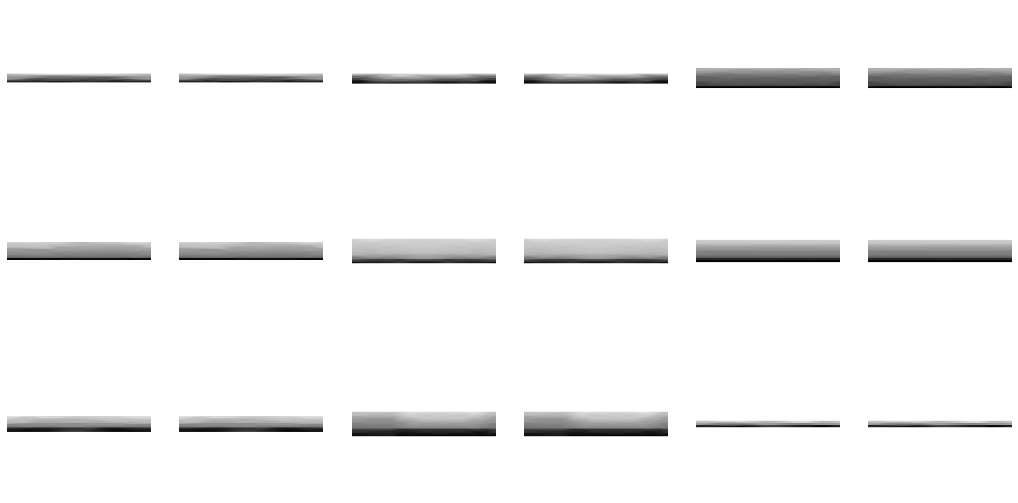

In [4]:
dls = DataBlock(
    blocks=(ImageBlock(cls=TiffImage), ImageBlock(cls=TiffImageNoised)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[resize_func],# AddNoiseTransform(std=1)], #RandomErasingTransform()], #AddNoiseTransform(std=1)],
    batch_tfms=[IntToFloatTensor(div=2**16-1), resize_func],
        ).dataloaders(DATA_DIRECTORY/f"images/energies{THRESHOLD}", bs=64)

dls.show_batch()

In [5]:
xb, yb = dls.one_batch()
yb.min()

TensorImageNoised(0., device='cuda:0')

(TensorImageBW(0., device='cuda:0'), TensorImageBW(0.7589, device='cuda:0'))

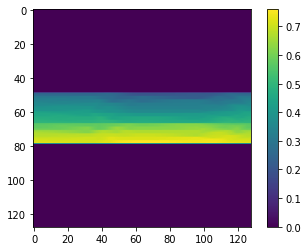

In [6]:
i=4
plt.imshow(xb[i][0].cpu()) 
plt.colorbar()
xb[i].min(), xb[i].max()

## Train

### Create Learner

epoch,train_loss,valid_loss,time
0,0.209490,0.212247,00:06
1,0.132383,0.033843,00:05
2,0.068342,0.021692,00:04
3,0.038183,0.014127,00:06
4,0.023255,0.010994,00:06
5,0.014590,0.006699,00:06
6,0.009863,0.005849,00:04
7,0.007626,0.005551,00:04
8,0.006525,0.005199,00:05
9,0.005916,0.005274,00:04


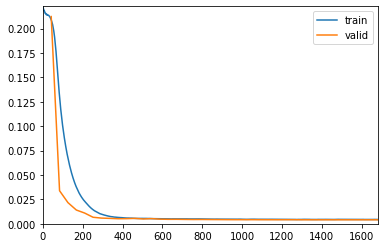

epoch,train_loss,valid_loss,time
0,0.176327,0.203227,00:05
1,0.094110,0.032138,00:04
2,0.053816,0.022556,00:05
3,0.032880,0.014373,00:04
4,0.020505,0.010006,00:05
5,0.013836,0.008174,00:05
6,0.010659,0.007144,00:05
7,0.008922,0.007193,00:05
8,0.008097,0.006694,00:05
9,0.007636,0.006678,00:05


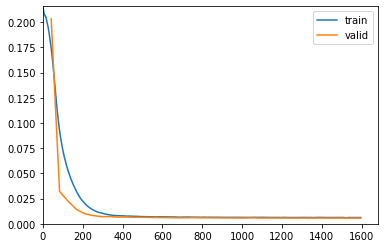

In [ ]:

from models import SimpleAutoencoder128, SimpleAutoencoderDeep128
n_latents = [256, 128, 64, 32, 16, 8, 4, 2]

for n in n_latents:
    ae = SimpleAutoencoderDeep128(n_latent=n)
    learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
    learn.fit_one_cycle(40)
    learn.export(f"trained_models/nearest_12_v1_length_{n}_padded_{PADDED}.pkl")

## View Predictions

In [ ]:
plot("2dm-26")

In [ ]:
image = TiffImage.create(DATA_DIRECTORY/"images/energies4/2dm-21.tiff")
out = learn.predict(image)

plt.imshow(out[2].numpy()[0])
plt.show()
image.show()

In [ ]:
view_prediction("2dm-29", learn.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH, height=SELECTED_HEIGHT, height_mode="squish")